### Logistic Regression with L2 Regulatization

We know that the Logistic Regression can be regarded as a no-hidden-layer neural network with sigmoid a sigmoid activation function in it's output. In simple terms, it can be explained as applying a transformation to the output of a linear regression.

Mathematically, this the following:

$$
\begin{align}
\hat{y} = \sigma(XW + b) \\
\sigma(Z) = \frac{1}{1 + e^{-Z}}
\end{align}
$$

Where $X \in \mathbb{R}^{n \times p}$ is the feature matrix, $y \in \mathbb{R}^{n \times 1}$ is the target vector, $W \in \mathbb{R}^{p \times 1}$ is the weights vector, and $b \in \mathbb{R}^{n \times 1}$ is the bias vector. $Z$ stands for the output of the linear regression and thus, it has the output dimensions of it, $Z \in \mathbb{R}^{n \times 1}$ in this case.

Now, we will consider the regular Logistic Regression loss function (binary cross-entropy) for the optimization problem, however, we are going to add a constraint that bounds the $L_2$ norm of the weight vector to be less or equal than certain scalar k. Formally, this is as it follows:

$$
\begin{align*}
\underset{W, b}{min} \quad - \sum^{n}_{i=1} y_i\log{(\hat{y})} + (1 - y_i)\log{(1 - \hat{y})} \\
s.t. \quad W^TW \leq k
\end{align*}
$$

Then, the Lagrangian formulation of the problem will be the following:

$$
\underset{W, b}{min}\, \underset{\lambda \geq 0}{max} \quad L(W, b, \lambda) = BCE(y, \hat{y}) + \lambda(W^tW - k)
$$

Where we exchanged the commonly used $L$ notation for the loss in order to maintain our function notation clean.

### Imports

In [5]:
%load_ext autoreload
%autoreload 2

import random
import os

import wandb
import torch
import numpy as np

from pipeline import load_breast_cancer_data, split_data, set_optimizers, train_model, evaluate_model
from plotting import plot_constrained_state_history, plot_unconstrained_state_history
from models import LogisticRegression, NormConstrainedLogisticRegression

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Ensure Reproducibility
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
torch.backends.cudnn.deterministic = True

# Wandb Login
wandb.login()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [12]:
BATCH_SIZE = 64
N_ITERS = 20000

### Model and Optimization Problem

In [13]:
dataset = MNIST(os.getcwd() + "/data", download=True, transform=transforms.ToTensor())
train_data, val_data, test_data = split_data(dataset, 0.6)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

num_epochs = int(N_ITERS / (len(train_data) / BATCH_SIZE))

### Unconstrained Model

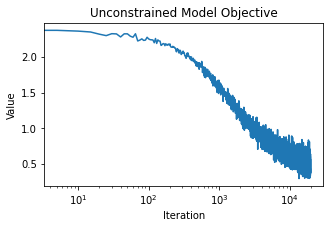

Train accuracy: 87.675
Validation accuracy: 87.75833333333334
Test accuracy: 87.64166666666667


In [14]:
# Train unconstrained model
is_constrained = False
primal_lr = 1e-3
unc_model = LogisticRegression(784, 10)
optimizer = torch.optim.SGD(unc_model.parameters(), lr=primal_lr)
criterion = torch.nn.CrossEntropyLoss()

unc_model, unc_state_history = train_model(unc_model,
                                        is_constrained,
                                        train_loader,
                                        optimizer,
                                        num_epochs,
                                        criterion=criterion,
                                        use_wandb=False)

plot_unconstrained_state_history(unc_state_history)

unc_train_accuracy = evaluate_model(unc_model, train_loader, 'train', use_wandb=False)
unc_val_accuracy = evaluate_model(unc_model, val_loader, 'val', use_wandb=False)
unc_test_accuracy = evaluate_model(unc_model, test_loader, 'test', use_wandb=False)

print(f'Train accuracy: {unc_train_accuracy}')
print(f'Validation accuracy: {unc_val_accuracy}')
print(f'Test accuracy: {unc_test_accuracy}')

### Constrained Model

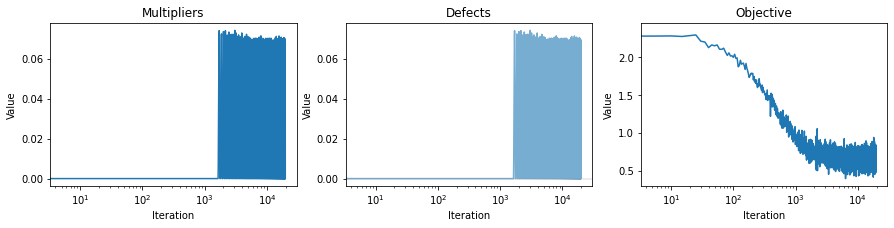

Train accuracy: 87.55277777777778
Validation accuracy: 87.425
Test accuracy: 87.63333333333334


In [15]:
# Train unconstrained model
is_constrained = True
con_model = LogisticRegression(784, 10)
cmp = NormConstrainedLogisticRegression()
primal_lr = 1e-3
dual_lr = 5e-3
formulation, optimizer = set_optimizers(cmp, con_model.parameters(), primal_lr, dual_lr)
k = 10

con_model, const_state_history = train_model(con_model,
                                        is_constrained,
                                        train_loader,
                                        optimizer,
                                        num_epochs,
                                        cmp=cmp,
                                        formulation=formulation,
                                        k=k,
                                        use_wandb=False)

plot_constrained_state_history(const_state_history)

const_train_accuracy = evaluate_model(con_model, train_loader, 'train', use_wandb=False)
const_val_accuracy = evaluate_model(con_model, val_loader, 'val', use_wandb=False)
const_test_accuracy = evaluate_model(con_model, test_loader, 'test', use_wandb=False)

print(f'Train accuracy: {const_train_accuracy}')
print(f'Validation accuracy: {const_val_accuracy}')
print(f'Test accuracy: {const_test_accuracy}')

### Other Problem

In [ ]:
dataset = load_breast_cancer_data()

print(f'Number of observations: {len(dataset)}')
print(f'Number of features: {dataset[0][0].shape[0]}')

train_data, val_data, test_data = split_data(dataset, 0.6)

print(f'Nuumber of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of testing samples: {len(test_data)}')

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)